## Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

# Part 1: General Analysis

In this notebook, we explore the provided dataset. 

### Table of contents
1. [Loading data and handling outliers movie metadata](#section1)
    - 1.1 [Loading all provided data](#section1-1)
    - 1.2 [Missing values and outliers](#section1-2)
      * 1.2.1 [Identifying missing values](#section1-2-1)
      * 1.2.2 [Outliers](#section1-2-2)
2. [Exploratory data analysis movie metadata](#section2)
    - 2.1 [Analysing genres](#section2-1)
    - 2.2 [Romantic movies runtime](#section2-2)
    - 2.3 [Romantic movies box office revenue](#section2-3)
    - 2.4 [Romantic movies countries](#section2-4)
    - 2.5 [Romantic movies languages](#section2-5)
    - 2.6 [Evolution over time](#section2-6)
      * 2.6.1 [Box office revenue over time](#section2-6-1)
      * 2.6.2 [Evolution of runtime](#section2-6-2)
3. [Exploratory data analysis character metadata](#section3)
    - 3.1 [Missing values and outliers](#section3-1)
    - 3.2 [Merging movie metadata and character metadata](#section3-2)
    - 3.3 [Gender analysis](#section3-3)
    - 3.4 [Age of actor analysis](#section3-4)
3. [TV Tropes](#section4)



In [1]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from nltk.tree import Tree
import xml.etree.ElementTree as ET
import itertools
import matplotlib.dates as mdates

from load_data import *
pd.options.mode.chained_assignment = None


## 1. Loading data and handling outliers <a class="anchor" id="section1"></a>

### 1.1 Loading provided data <a class="anchor" id="section1-1"></a>

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summary of each movie, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv). We extract all coreNLP files, then uncompress them to the XML format. Note: Extraction of CoreNLP files takes 15 minutes, while conversion takes 30 seconds.

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

`name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

`tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [320]:
download_data()

# Load plot summaries
# plot_df = load_plot_df()

# Load movie metadata
movie_df = load_movie_df()

# Load character metadata
char_df = load_char_df()

# Load name clusters
names_df = load_names_df()

# Load tv tropes
cluster_df = load_cluster_df()

In [78]:
# Find number of missing values for each column
missing_values = movie_df.isnull().sum()
missing = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in movie_df.columns:
    missing.append([col, missing_values[col], round(missing_values[col]/len(movie_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))

,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Name,0,0.00
Release date,6902,8.44
Box office revenue,73340,89.72
Runtime,20450,25.02
Languages,13866,16.96
Countries,8154,9.98
Genres,2294,2.81


#### 1.2.2 Outliers <a class="anchor" id="section1-2-2"></a>
The data contains some outliers, we have observed the following points:

- We note that there is one movie with a release date in the year 1010 ('Hunting season'), we manually correct this to the date 2010
- There are many movies with very short runtimes (under 5 minutes). We manually verified a sample of these movies, and have found that the runtimes are correct. They mostly correspond to short movies from the early 20th century.
- There are over a hundred movies with runtimes over 5 hours. We have found that most of these data points correspond to series, where the runtime is the sum of the episode lengths.
- One movie has a runtime of over a million minutes ('Zero tolerance'). This lengths is manually corrected to 88 minutes.

In [79]:
# Isolate the year from the release date
getYear = lambda x: x[slice(0,4)] if type(x) == str else x
movie_df['Release date'] = movie_df['Release date'].apply(getYear)

# Correct release date of 1010
movie_df['Release date'][movie_df['Wikipedia ID']==29666067] = '2010'

# Correct runtime of over a million minutes
movie_df['Runtime'][movie_df['Wikipedia ID']==10815585] = 88

def sanitycheck(df):
    # Remove movies with nan for release date or nan for runtime
    df = df[df['Release date'].notna()]
    df = df[df['Runtime'].notna()]
    # Make a boolean that is true if there is a release date before 1900
    before1900 = any(df['Release date'].apply(lambda x: int(x) < 1880))
    # Make a boolean that is true if there is a runtime over 20000 minutes
    # Note that we allow long runtimes, as we keep series in the dataset
    over10hours = any(df['Runtime'].apply(lambda x: int(x) > 20000))
    if before1900 or over10hours:
        print('Sanity check failed')
    else:
        print('Sanity check passed')
sanitycheck(movie_df)

Sanity check passed


## 2. Exploratory data analysis on movies <a class="anchor" id="section2"></a>

### 2.1 Analysing genres <a class="anchor" id="section2-1"></a>

Let us first find the total number of unique genres and plot the 10 most occuring genres. The plot shows that drama occurs much more than the other genres. The subsequent genres have a similar appearance frequency. 

Number of unique genres:  363


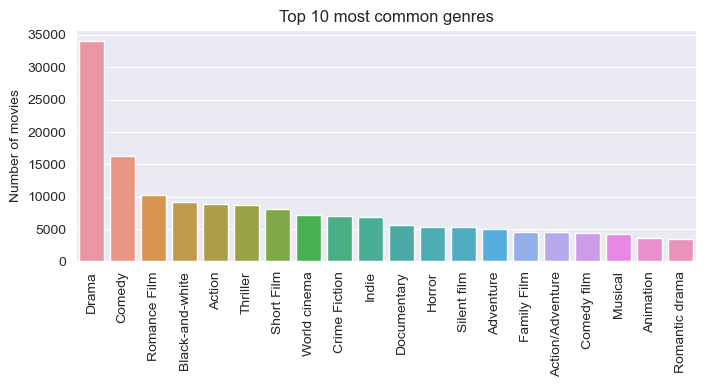

In [321]:
#Remove missing genres
genres = movie_df['Genres'].apply(lambda x: x if type(x) == list else [])

# Find number of unique genres
unique_genres = set(itertools.chain.from_iterable(genres))
print('Number of unique genres: ', len(unique_genres))

# Find top 10 most common genres
genre_counts = {}
for genre in unique_genres:
    genre_counts[genre] = sum(genres.apply(lambda x: genre in x))
genre_counts = {k: v for k, v in sorted(
    genre_counts.items(), key=lambda item: item[1], reverse=True)}
genre_counts = {k: genre_counts[k] for k in list(genre_counts)[:10]}


# Plot histogram with top 10 most common genres using seaborn
plt.figure(figsize=(8, 3))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=90)
plt.title('Top 10 most common genres')
sns.set_palette("flare")
sns.set_style('darkgrid')
plt.ylabel('Number of movies')
plt.show()



In [340]:
# Count the number of movies per year
movie_df['Release date year'] = movie_df['Release date'].apply(lambda x: int(str(x)[:4]))
movie_df['Release date year'].value_counts()[1902]

7

In [341]:
for i in range(10):
    print(movie_df['Release date year'].value_counts()[1900+i])

33
23
7
13
1
9
11
24
31
41


In [342]:
# Get relaase date by decade
movie_df['Release date decade'] = movie_df['Release date year'].apply(lambda x: int(x/10)*10)
movie_df['Release date decade'].value_counts()[1900]

193

In [344]:
#romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
#romance_genres = ['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie']
# Take the top 20 genres and look at their evolution through time 
romance_genres = ['Drama',
 'Comedy',
 'Romance Film',
 'Black-and-white',
 'Action',
 'Thriller',
 'Short Film',
 'World cinema',
 'Crime Fiction',
 'Indie',
 'Documentary',
 'Horror',
 'Silent film',
 'Adventure',
 'Family Film',
 'Action/Adventure',
 'Comedy film',
 'Musical',
 'Animation',
 'Romantic drama']

def is_romantic(i): return lambda x: any(
    y in romance_genres[i] for y in x) if type(x) == list else False

romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]
romance_movies = romance_movies[~romance_movies['Release date'].isna()]

# For romance movies, plotly the proportion of romantic genres per decade with a slider
# Create a dictionary with the number of movies per decade per genre
genre_counts = {}
for year in range(1880, 2021, 10):
    genre_counts[year] = {}
    for genre in romance_genres:
        genre_counts[year][genre] = romance_movies[romance_movies['Release date'].apply(lambda x: year <= int(str(x)[:4]) < (year+10)) & romance_movies['Genres'].apply(lambda x: (genre in x))]

genre_counts_prop = {}
for year in range(1880, 2020, 10):
    genre_counts_prop[year] = {}
    for genre in genre_counts[year].keys():
        genre_counts_prop[year][genre] = len(genre_counts[year][genre]) 
    

# Create a dataframe with the proportion of movies per year per genre
genre_counts_prop_df = pd.DataFrame(genre_counts_prop)
genre_counts_prop_df = genre_counts_prop_df.reset_index()
genre_counts_prop_df = genre_counts_prop_df.rename(columns={'index': 'Genre'})
genre_counts_prop_df = genre_counts_prop_df.melt(id_vars=['Genre'], var_name='Decade', value_name='Number of movies')
genre_counts_prop_df['Proportion of movies'] = genre_counts_prop_df.apply(lambda x: x['Number of movies'] / movie_df['Release date decade'].value_counts()[x['Decade']], axis=1)
genre_counts_prop_df['Proportion of movies in percentage'] = genre_counts_prop_df['Proportion of movies'].apply(lambda x: round(x*100, 2))
genre_counts_prop_df['Number of movies'] = genre_counts_prop_df['Number of movies'].apply(lambda x: "Nbr movies: " + str(x))

In [352]:
import plotly.express as px

fig = px.bar(genre_counts_prop_df, x="Genre", y="Proportion of movies in percentage", animation_frame="Decade", animation_group="Genre", color="Genre", hover_name="Number of movies", range_y=[0, 80])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()
fig.update_layout(showlegend=False)
# center the title

fig.update_layout(
    title="Distribution of movies genres across time",
    yaxis_title="Proportion of movies genre by decade in percentage",
    )
    # control the speed of the animation
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    args=[None, {"frame": {"duration": 500, "redraw": False},
                                    "fromcurrent": True, "transition": {"duration": 400, "easing": "quadratic-in-out"}}],
                    label="Play",
                    method="animate"
                ),
                dict(
                    args=[[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",    
                                    "transition": {"duration": 0}}],
                    label="Pause",
                    method="animate"
                )
            ]
        )
    ]
)
fig.update_layout(
    title={
        'text': "Distribution of movies genres across time",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.write_html("genre_distrib.html")

Let us now focus on the romantic genres and discover the different flavors. The plot below shows that romantic films, romantic comedies and romantic dramas are most present. There are fewer romantic fantasy's, and just 1 romantic thriller - [Bloody isshq](https://en.wikipedia.org/wiki/Bloody_Isshq), which tells the tale of Natasha, a "brash, deviant man-eater". 

,Number of movies
Genre,
Romantic comedies,2680
Romantic films,10234
Romantic drama,3372
Romantic fantasy,72
Romantic thriller,1


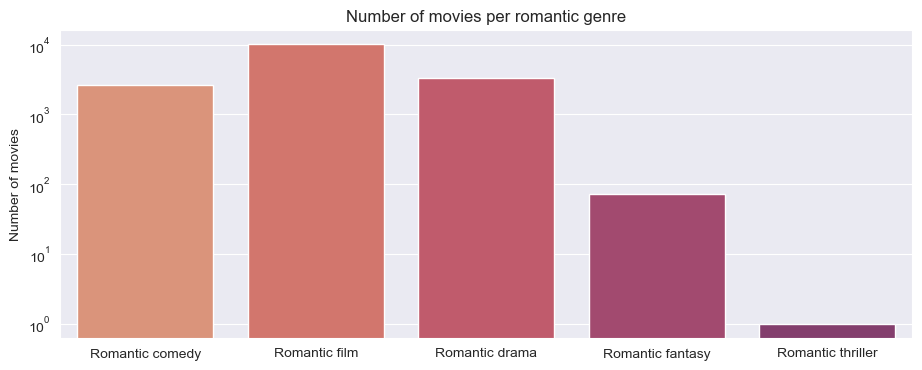

In [6]:
romance_genres = ['Romantic comedy', 'Romance Film',
                  'Romantic drama', 'Romantic fantasy', 'Romantic thriller']


def is_romantic(i): return lambda x: any(
    y in romance_genres[i] for y in x) if type(x) == list else False


def is_not_romantic(i): return lambda x: not any(
    y in romance_genres[i] for y in x) if type(x) == list else False


romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies = movie_df[movie_df['Genres'].apply(is_not_romantic(slice(0, 5)))]

#Organize by category
romantic_comedy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(0))]
romantic_film = romance_movies.loc[movie_df['Genres'].apply(is_romantic(1))]
romantic_drama = romance_movies.loc[movie_df['Genres'].apply(is_romantic(2))]
romantic_fantasy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(3))]
romantic_thriller = romance_movies.loc[movie_df['Genres'].apply(
    is_romantic(4))]

num_movies = [['Romantic comedies', romantic_comedy.shape[0]], ['Romantic films', romantic_film.shape[0]], ['Romantic drama', romantic_drama.shape[0]], ['Romantic fantasy', romantic_fantasy.shape[0]], ['Romantic thriller', romantic_thriller.shape[0]]]
table = [['Genre', 'Number of movies']] + num_movies
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Genre'))

# Using seaborn, make a barplot with the number of movies per romantic genre with log axes
plt.figure(figsize=(11, 4))
sns.barplot(x=['Romantic comedy', 'Romantic film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller'], y=[
            romantic_comedy.shape[0], romantic_film.shape[0], romantic_drama.shape[0], romantic_fantasy.shape[0], romantic_thriller.shape[0]])
plt.yscale('log')
plt.title('Number of movies per romantic genre')
plt.ylabel('Number of movies')
# Add color palette green
sns.set_palette("flare")
# Add dark background
sns.set_style('darkgrid')
plt.show()


**Frequent itemset mining introduction**

Up to now, we have not considered combinations of genres. Let us now investigate which genres often cooccur together. To do so, we use frequent itemset mining. Let us first introduce several concepts, before diving into the analysis. We define the support of a genre as follows:

$\text{Support(genre X)}=\frac{\text{Number of movies with genre X}}{\text{Total number of movies}}$

The support thus tells us how prevalent a genre is in the dataset. We can also calculate the support for multiple genres together, such as "comedy" and "action", we then divide the number of movies with **both** action and comedy as a genre by the total number of movies. 

To analyze the cooccurence of genres, we use the lift measure:

$\text{lift(genre X and genre Y)} = \frac{\text{Support(genre X and genre Y)}}{\text{Support(genre X)} \cdot \text{Support(genre Y)}}$

Intuitively, if the lift is higher than 1, it means that 2 genres cooccur more frequently than one would expect based on their individual supports. This gives a natural threshold, if the lift is higher than 1, we have found an association between 2 genres.

**Analysis of results**

The heatmap below shows several association rules. The most prominent association is between action and action/adventure, which is not surprising. More interestingly, we see that drama is associated with many other genres. This explains the high presence of the drama genre that we saw before, as it is thus paired with many other genres. 

When we focus on the romantic movies, we see that romance film is associated with comedy and drama. This is in line with what we saw before, as romantic comedies and romantic dramas are the most present romantic genres in the data.

In [7]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Encode using one-hot encoding
tr = TransactionEncoder()
tr_arr = tr.fit(genres).transform(genres)
one_hot = pd.DataFrame(tr_arr, columns=tr.columns_)

# Find frequent itemsets
freq_itemsets = apriori(one_hot, min_support=0.04, use_colnames=True)

# Find association rules
associations = association_rules(freq_itemsets, metric="lift", min_threshold=1)

# Rank association rules by confidence
associations = associations.sort_values(by='lift', ascending=False)
associations['antecedents'] = associations['antecedents'].apply(
    lambda x: list(x)[0])
associations['consequents'] = associations['consequents'].apply(
    lambda x: list(x)[0])
# Plot heatmap of association rules with annotations and without colorbar, no xlabel and ylabel
plt.figure(figsize=(5, 5))
sns.heatmap(associations.pivot(index='antecedents', columns='consequents',
            values='lift'), annot=True, cbar=False, cmap='Blues')
plt.title('Association rules with lift measures')
#remove xlabel and ylabel
plt.xlabel('')
plt.ylabel('')
plt.show()


ModuleNotFoundError: No module named 'mlxtend'

### 2.2. Romantic movies runtime <a class="anchor" id="section2-2"></a>

Let us then analyze the runtime of romantic and non-romantic movies. We note three findings:

- Romantic comedies seem to have a lower variance in their runtime. This indicates that most romantic comedies have a runtime of approximately 100 minutes, with a relatively low spread. Intuitively, one can think of all romantic christmas comedies popping up on netflix in december, which are usually about this length.
- Non-romantic movies have a slightly lower runtime on average. There is a second peak in the density around 0-25 minutes. This corresponds to short movies, which were most present in the early 20th century.
- Among the longer movies, romantic dramas are most present. This genre thus has relatively many long movies.

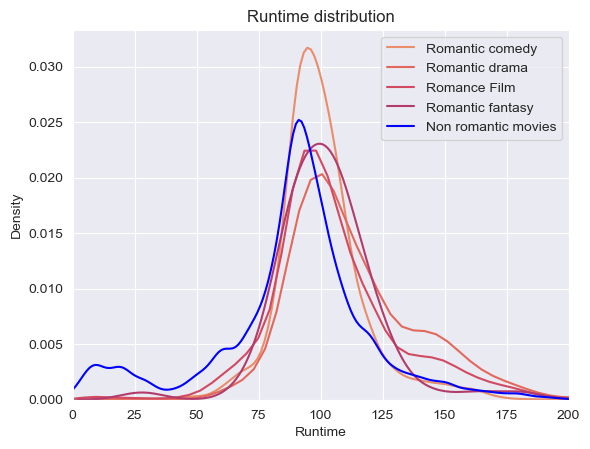

In [8]:
ax = sns.kdeplot(romantic_comedy['Runtime'])
ax = sns.kdeplot(romantic_drama['Runtime'])
ax = sns.kdeplot(romantic_film['Runtime'])
ax = sns.kdeplot(romantic_fantasy['Runtime'])

#remove runtime over 200 for non romantic movies
non_romance_movies = non_romance_movies[non_romance_movies['Runtime'] < 200]

ax = sns.kdeplot(non_romance_movies['Runtime'], color='blue')
ax.set_xlim(0, 200)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film',
          'Romantic fantasy', 'Non romantic movies'])
plt.title('Runtime distribution')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


In [9]:
#Find 5 movies with shortest runtime
shortest_runtime = movie_df.sort_values(by='Runtime', ascending=True)
shortest_runtime.head(5)
display(shortest_runtime)

,Wikipedia ID,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,1894,NaN,0.000000,[English],[United States of America],[Short Film]
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.030000,[Silent film],[United Kingdom],"[Short Film, Silent film, Indie, Black-and-white]"
55686,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaN,NaN,0.050000,[Silent film],[United States of America],"[Short Film, Silent film]"
25984,644824,/m/02_1qn,Dickson Greeting,1891,NaN,0.050000,NaN,[United States of America],"[Short Film, Indie]"
7486,32175981,/m/0gy0t95,Men Boxing,1891,NaN,0.083333,[Silent film],NaN,"[Short Film, Silent film]"
...,...,...,...,...,...,...,...,...,...
81713,7762741,/m/0kvgqq,Business Versus Love,1914,NaN,NaN,NaN,[United States of America],"[Short Film, Silent film, Drama]"
81724,19286279,/m/04ldgm4,Kalai Arasi,1963,NaN,NaN,[Tamil],[India],"[Romance Film, Action, Drama, Science Fiction]"
81729,15394941,/m/03m6zh4,Gopi Kishan,1994,NaN,NaN,[Hindi],[India],"[Drama, Action, Crime, Comedy]"
81731,23687925,/m/06zmdnc,La Ragazza di Trieste,1952,NaN,NaN,[Italian],[Italy],"[Romance Film, Drama]"


### 2.3. Romantic movies box office revenue <a class="anchor" id="section2-3"></a>

Next, we discuss the box office revenue of romantic and non-romantic movies. Specifically, there are two findings:
- Romantic fantasy movies generate a higher revenue, on average. However, we note that there are only 72 romantic fantasy's in the dataset, which is a small sample. In this sample, there are several blockbusters, such as twilight (which is the prime example of the absence of a direct relation between revenue and quality).
- Romantic comedies yield a slightly higher revenue than romantic dramas, romance films and non-romantic movies.

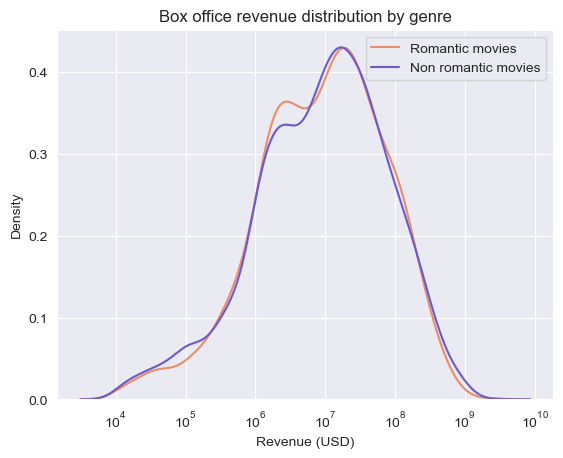

In [10]:
ax = sns.kdeplot(romance_movies['Box office revenue'], log_scale=True)
ax = sns.kdeplot(non_romance_movies['Box office revenue'], log_scale=True, color='slateblue')
colors = [line.get_color() for line in ax.get_lines()]
ax.legend(['Romantic movies', 'Non romantic movies'])
plt.title('Box office revenue distribution by genre')
plt.xlabel('Revenue (USD)')
plt.ylabel('Density')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


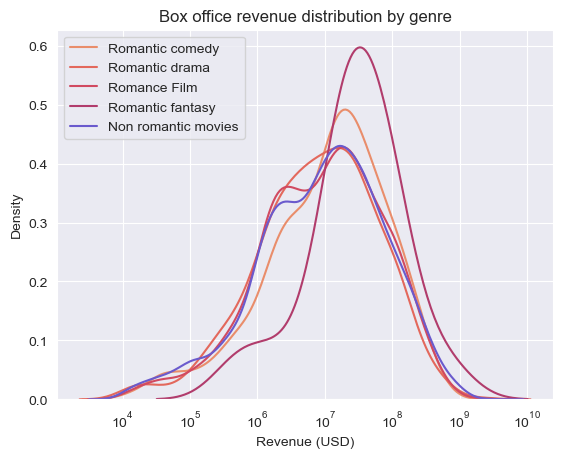

In [11]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True)
ax = sns.kdeplot(non_romance_movies['Box office revenue'], log_scale=True, color='slateblue')
colors = [line.get_color() for line in ax.get_lines()]
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])
plt.title('Box office revenue distribution by genre')
plt.xlabel('Revenue (USD)')
plt.ylabel('Density')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


### 2.4. Romantic movies countries <a class="anchor" id="section2-4"></a>

Let us now consider the country of production of movies. The histogram below shows that generally a movie is made in one country. Romantic fantasies are more often produced in multiple countries, however, also for this genre 75% is produced in one country.

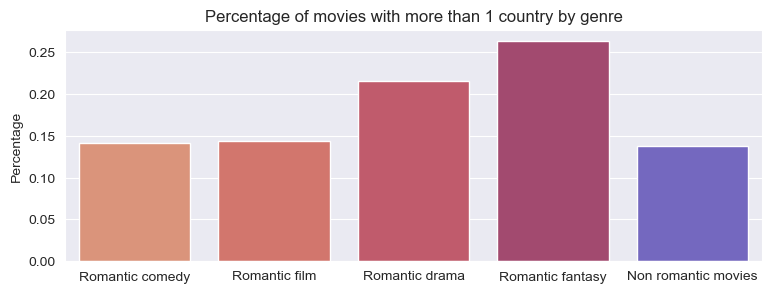

In [12]:
# Store number of countries for each movie
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)
non_romance_movies['number_countries'] = non_romance_movies['Countries'].apply(get_countries)

#Plot percentage of movies with more than 1 country, for romantic genres and non-romantic movies
plt.figure(figsize=(9, 3))
sns.barplot(x=['Romantic comedy', 'Romantic film', 'Romantic drama', 'Romantic fantasy', 'Non romantic movies'], y=[
                romantic_comedy[romantic_comedy['number_countries'] > 1].shape[0]/romantic_comedy.shape[0], romantic_film[romantic_film['number_countries'] > 1].shape[0]/romantic_film.shape[0], romantic_drama[romantic_drama['number_countries'] > 1].shape[0]/romantic_drama.shape[0], romantic_fantasy[romantic_fantasy['number_countries'] > 1].shape[0]/romantic_fantasy.shape[0], non_romance_movies[non_romance_movies['number_countries'] > 1].shape[0]/non_romance_movies.shape[0]], 
                palette=colors)
plt.title('Percentage of movies with more than 1 country by genre')
plt.ylabel('Percentage')
sns.set_style('darkgrid')
plt.show()

Let us then dive into which countries are most present. For each genre, the USA is by far the most frequent country of production. We note a few differences in the production country between genres:
- India is common for romantic dramas and romance movies, but is less prevalent for romantic comedies. For romantic fantasy's, India is not even in the top 5.
- While Italy is in the top 5 for non-romantic movies and romantic dramas, it is not in the top 5 for other romance genres. 
- Germany is in the top 5 for romantic comedy's and romance films, but not for non-romantic films. 

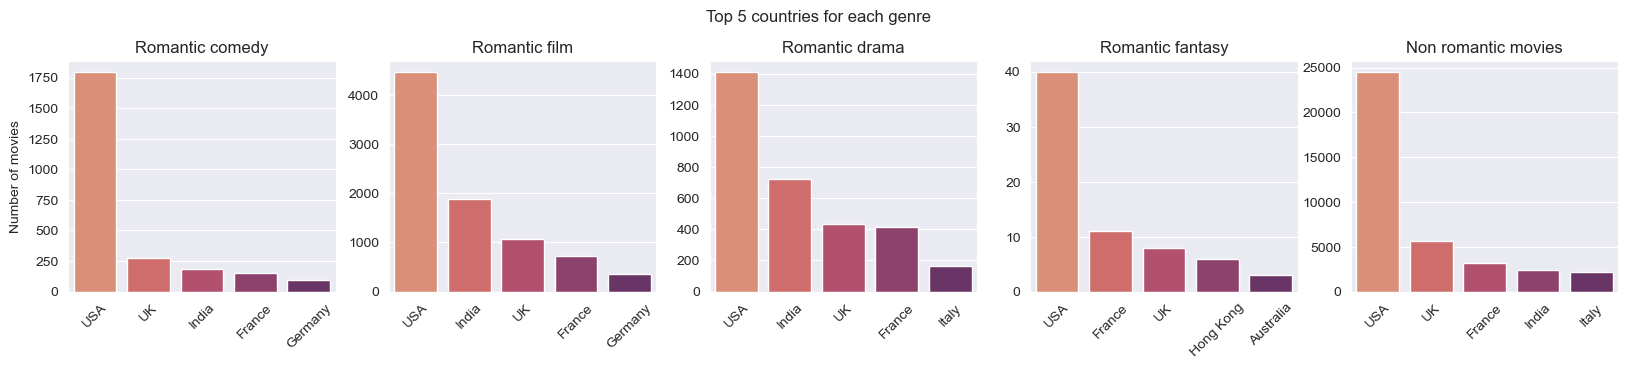

In [13]:
#Find the five most frequent countries for each romantic genre, and plot them for each genre
romantic_comedy_countries = romantic_comedy['Countries'].explode().value_counts().head(5)
romantic_film_countries = romantic_film['Countries'].explode().value_counts().head(5)
romantic_drama_countries = romantic_drama['Countries'].explode().value_counts().head(5)
romantic_fantasy_countries = romantic_fantasy['Countries'].explode().value_counts().head(5)
non_romance_countries = non_romance_movies['Countries'].explode().value_counts().head(5)

# Make a multi figure plot with 5 subplots, each giving top 5 countries for each romantic genre and for non-romantic movies using seaborn
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
sns.barplot(x=romantic_comedy_countries.index, y=romantic_comedy_countries.values, ax=axs[0], palette='flare')
sns.barplot(x=romantic_film_countries.index, y=romantic_film_countries.values, ax=axs[1], palette='flare')
sns.barplot(x=romantic_drama_countries.index, y=romantic_drama_countries.values, ax=axs[2], palette='flare')
sns.barplot(x=romantic_fantasy_countries.index, y=romantic_fantasy_countries.values, ax=axs[3], palette='flare')
sns.barplot(x=non_romance_countries.index, y=non_romance_countries.values, ax=axs[4], palette='flare')
axs[0].set_title('Romantic comedy')
axs[1].set_title('Romantic film')
axs[2].set_title('Romantic drama')
axs[3].set_title('Romantic fantasy')
axs[4].set_title('Non romantic movies')
axs[0].set_ylabel('Number of movies')
#Rotate x labels
for ax in axs.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
fig.suptitle('Top 5 countries for each genre', y=1.05)
sns.set_style('darkgrid')
for ax in axs.flat:
    ax.set_xticklabels([label.get_text().replace('United States of America', 'USA').replace('United Kingdom', 'UK') for label in ax.get_xticklabels()])
plt.show()

### 2.5. Movie languages <a class="anchor" id="section2-5"></a>

Let us then find the most common languages spoken in romantic movies and non-romantic movies. We see that in romantic movies, Hindi and Tamil are in the top 5 languages, whereas this is not the case for non-romantic movies. This is in line with the large role of india in the production of romance films and romantic dramas, which we saw in the analysis in 3.4. Furthermore, we see that japanese and italian are in the top 5 for non-romantic movies. However, these languages are absent for romantic movies.

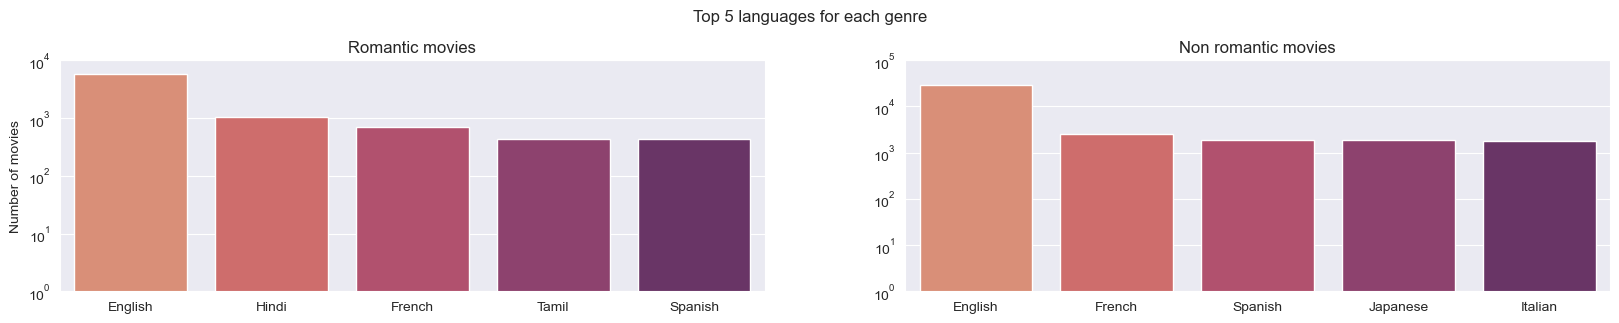

In [14]:
#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)

#Plot 5 most common languages in non romantic movies
non_romance_movies_lang = non_romance_movies[non_romance_movies['Languages'].notnull()]
languages_non_romance = non_romance_movies_lang.Languages.sum()
values_non_romance, counts_non_romance = np.unique(languages_non_romance, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(20, 3))
sns.barplot(x=values[counts.argsort()[-5:][::-1]], y=counts[counts.argsort()[-5:][::-1]], ax=axs[0], palette='flare')
sns.barplot(x=values_non_romance[counts_non_romance.argsort()[-5:][::-1]], y=counts_non_romance[counts_non_romance.argsort()[-5:][::-1]], ax=axs[1], palette='flare')
axs[0].set_title('Romantic movies')
axs[1].set_title('Non romantic movies')
axs[0].set_ylabel('Number of movies')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_yticks([1, 10, 100, 1000, 10000])
axs[1].set_yticks([1, 10, 100, 1000, 10000, 100000])
fig.suptitle('Top 5 languages for each genre', y=1.05)
sns.set_style('darkgrid')
plt.show()



### 2.6. Evolution over time <a class="anchor" id="section2-6"></a>

As a last part of the exploratory analysis of the movie metadata, we investigate the evolution of the box office revenue and the runtime over the years. 

#### 2.6.1 Box office revenue over time <a class="anchor" id="section2-6-1"></a>

Generally, we see that for both romantic and non-romantic movies the box office revenue has increased over time. The large spikes for the romantic movies correspond to outliers. Two of these outliers are "Snow white and the seven dwarfs (1937)" and "The sound of music (1965)".

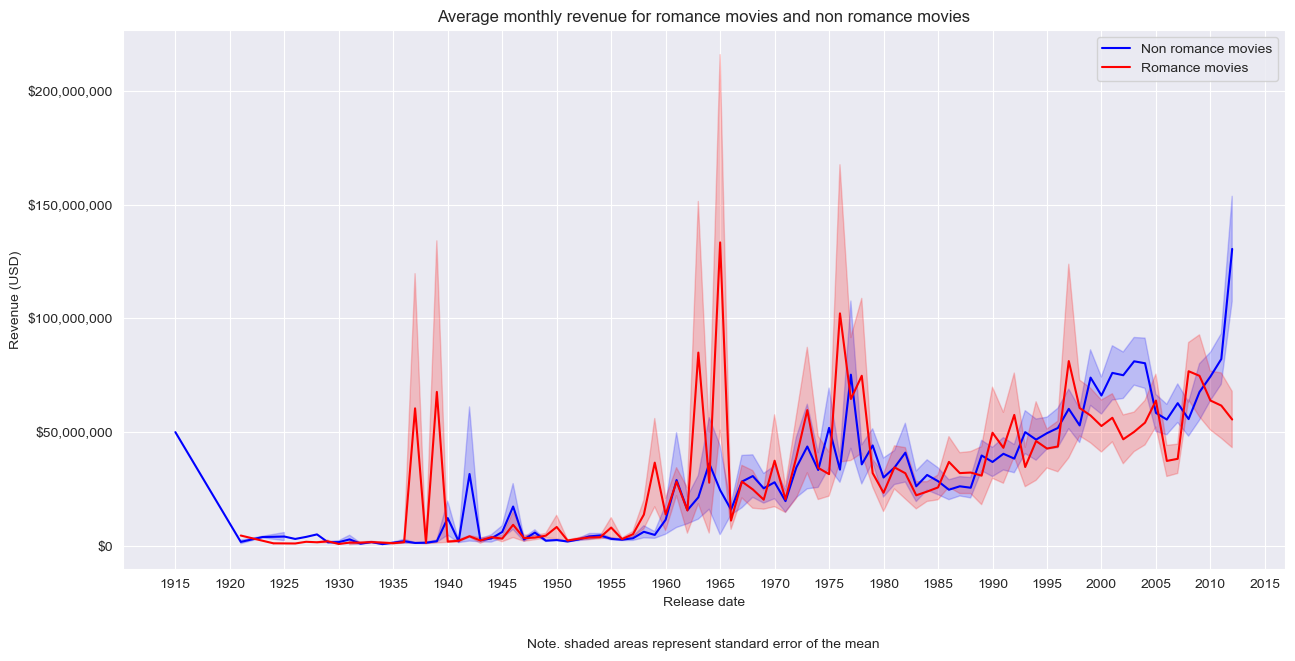

In [15]:
year_box_office = non_romance_movies[[
    'Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[[
    'Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(
    year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(
    year_box_office_romance['Release date'])

# Get yearly box office revenue for romantic and non-romantic movies
year_box_office = non_romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(year_box_office_romance['Release date'])

total_mean = year_box_office.groupby('Release date').mean().iloc[1:]
romance_mean = year_box_office_romance.groupby('Release date').mean().iloc[1:]
#Compute standard error of the mean for non-romantic movies and romantic movies
total_sem = year_box_office.groupby('Release date').sem().iloc[1:]
romance_sem = year_box_office_romance.groupby('Release date').sem().iloc[1:]

# Plot average monthly revenue for romance movies and non romance movies using seaborn
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=total_mean, x=total_mean.index, y='Box office revenue', color='blue', label='Non romance movies', ax=ax)
sns.lineplot(data=romance_mean, x=romance_mean.index, y='Box office revenue', color='red', label='Romance movies', ax=ax)
ax.fill_between(total_mean.index, total_mean['Box office revenue'] - total_sem['Box office revenue'], total_mean['Box office revenue'] + total_sem['Box office revenue'], color='blue', alpha=0.2)
ax.fill_between(romance_mean.index, romance_mean['Box office revenue'] - romance_sem['Box office revenue'], romance_mean['Box office revenue'] + romance_sem['Box office revenue'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_xlabel('Release date')
ax.set_ylabel('Revenue (USD)')
ax.set_title('Average monthly revenue for romance movies and non romance movies')
ax.legend()
ax.annotate('Note. shaded areas represent standard error of the mean', xy=(0.5, 0), xytext=(
    0, -50), xycoords='axes fraction', textcoords='offset points', size=10, ha='center', va='top')
plt.show()



### 2.6.2. Evolution of runtime <a class="anchor" id="section2-6-2"></a>

Last, we consider the runtime of romantic movies and non-romantic movies over time. The plot below mostly confirms the findings from before. We see that in the early 20th century, the average runtime sharply increases. This corresponds to the transition from short movies to longer movies. This increase slowly stagnates and the curve flattens. Overall, we see that romantic movies last longer on average. 

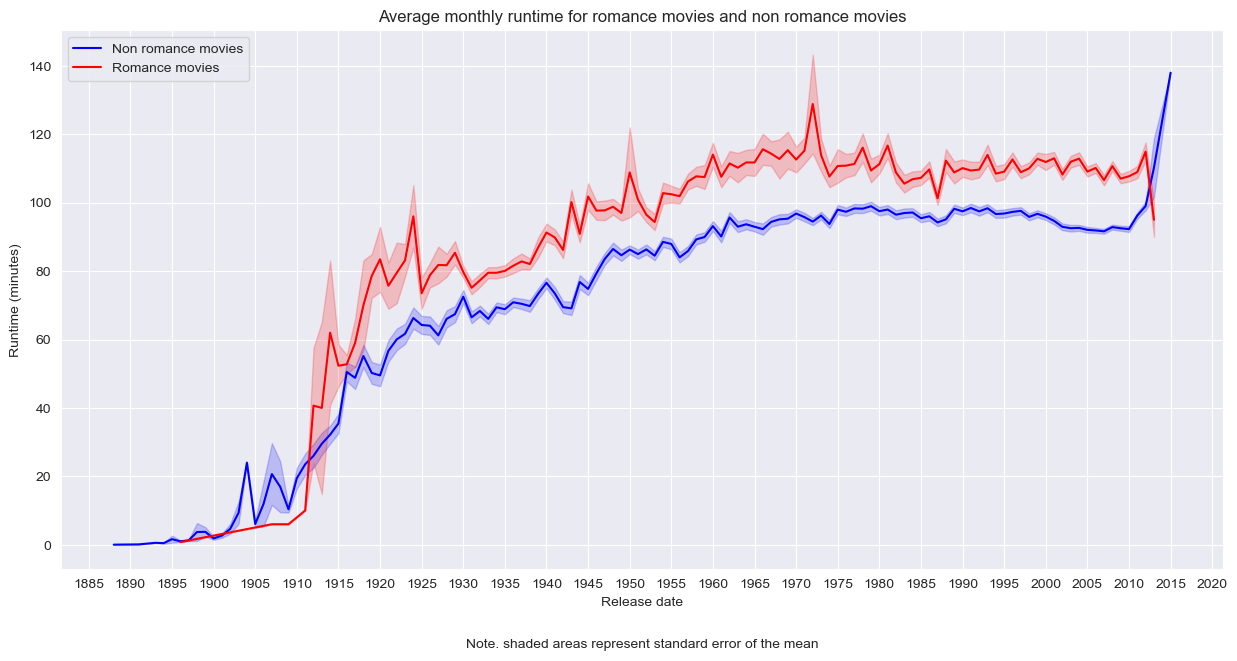

In [16]:
import matplotlib

# Get yearly runtime for romantic and non-romantic movies
year_runtime = non_romance_movies[['Release date', 'Runtime']].dropna()
year_runtime_romance = romance_movies[['Release date', 'Runtime']].dropna()
year_runtime['Runtime'] = year_runtime['Runtime'].astype(float)
year_runtime_romance['Runtime'] = year_runtime_romance['Runtime'].astype(float)

total_runtime_mean = year_runtime.groupby('Release date').mean()
romance_runtime_mean = year_runtime_romance.groupby('Release date').mean()
total_runtime_sem = year_runtime.groupby('Release date').sem().replace(np.nan, 0)
romance_runtime_sem = year_runtime_romance.groupby('Release date').sem().replace(np.nan, 0)

# Convert release date of mean and std to datetime
total_runtime_mean.index = pd.to_datetime(total_runtime_mean.index)
romance_runtime_mean.index = pd.to_datetime(romance_runtime_mean.index)
total_runtime_sem.index = pd.to_datetime(total_runtime_sem.index)
romance_runtime_sem.index = pd.to_datetime(romance_runtime_sem.index)


# Plot average monthly runtime for romance movies and non romance movies using seaborn
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=total_runtime_mean, x=total_runtime_mean.index, y='Runtime', color='blue', label='Non romance movies', ax=ax)
sns.lineplot(data=romance_runtime_mean, x=romance_runtime_mean.index, y='Runtime', color='red', label='Romance movies', ax=ax)
ax.fill_between(total_runtime_mean.index, total_runtime_mean['Runtime'] - total_runtime_sem['Runtime'], total_runtime_mean['Runtime'] + total_runtime_sem['Runtime'], color='blue', alpha=0.2)
ax.fill_between(romance_runtime_mean.index, romance_runtime_mean['Runtime'] - romance_runtime_sem['Runtime'], romance_runtime_mean['Runtime'] + romance_runtime_sem['Runtime'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Release date')
ax.set_ylabel('Runtime (minutes)')
ax.set_title('Average monthly runtime for romance movies and non romance movies')
ax.legend()
#Add footnote stating that the shaded areas represent standard error of the mean, position footnote underneath graph, small lettertype
ax.annotate('Note. shaded areas represent standard error of the mean', xy=(0.5, 0), xytext=(
    0, -50), xycoords='axes fraction', textcoords='offset points', size=10, ha='center', va='top')
plt.show()


## 3. Exploratory analysis on characters <a class="anchor" id="section3"></a>

Let us now investigate the character metadata.

### 3.1 Missing values and outliers <a class="anchor" id="section3-1"></a>



In [17]:
# Find number of missing values for each column
missing_values = movie_df.isnull().sum()
missing = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in movie_df.columns:
    missing.append([col, missing_values[col], round(missing_values[col]/len(movie_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))

,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Name,0,0.00
Release date,6902,8.44
Box office revenue,73340,89.72
Runtime,20450,25.02
Languages,13866,16.96
Countries,8154,9.98
Genres,2294,2.81


In [18]:
# Find number of missing values for each column
missing_values = char_df.isnull().sum()
missing_char = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in char_df.columns:
    missing_char.append([col, missing_values[col], round(missing_values[col]/len(char_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing_char
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))




,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Release date,9995,2.22
Character name,257875,57.22
Date of birth,106145,23.55
Gender,45609,10.12
Height,295845,65.65
Ethnicity,344611,76.47
Actor name,1228,0.27


In [19]:
# Divide height by 100 if the height is larger than 2.4 meters
char_df.loc[char_df['Height'] > 2.4, 'Height'] = char_df['Height']/100

# Remove rows with actors with an age over 100 and print number of rows that were removed
print('Number of rows removed for ages over 100 years: ', len(char_df.loc[char_df['Actor age at release'] > 100]))
char_df = char_df[char_df['Actor age at release'] < 100]

# Remove rows with actors with an age under 0 and print number of rows that were removed
print('Number of rows removed for ages under 0 years: ', len(char_df.loc[char_df['Actor age at release'] < 0]))
char_df = char_df[char_df['Actor age at release'] > 0]

# Remove rows with actors with a height under 1 meter and print number of rows that were removed
print('Number of rows removed for heights under 1 meters: ', len(char_df.loc[char_df['Height'] < 1.2]))
char_df = char_df[char_df['Height'] > 1]

def sanitycheck(df):
    # Check if there are any values above 2.5 meters or below 1 meter
    if (df['Height'].max() > 2.5) or (df['Height'].min() < 1):
        print('Sanity check failed: Height')
    # Check if there are any values above 100 years or below 0 years
    if (df['Actor age at release'].max() > 100) or (df['Actor age at release'].min() < 0):
        print('Sanity check failed: Age')
    else:
        print('Sanity check passed')

sanitycheck(char_df)

Number of rows removed for ages over 100 years:  2
Number of rows removed for ages under 0 years:  381
Number of rows removed for heights under 1 meters:  191
Sanity check failed: Height
Sanity check passed


### 3.2 Merging movie metadata and character metadata <a class="anchor" id="section3-2"></a>

We now merge the character metadata and the movie metadata. We merge on both the wikipedia ID and freebase ID, the results below show us that no data is lost from the character metadata. We do see that the release date of the character metadata and movie metadata often do not match. 

In [20]:
#Change release date in character dataframe to year
char_df['Release date'] = char_df['Release date'].apply(getYear)      

# Merge movie metadata and character metadata by wikipedia ID, freebase ID and release date
movie_char_df = pd.merge(movie_df, char_df, how='inner', left_on=['Wikipedia ID', 'Freebase ID', 'Release date'], right_on=['Wikipedia ID', 'Freebase ID', 'Release date'])

# print number of rows that were lost in the merge
print('Number of rows in merged movie and character dataframe: ', len(movie_char_df))
print('Number of rows in movie dataframe: ', len(movie_df))
print('Number of rows in character dataframe: ', len(char_df))

# Filter the romantic and non-romantic movies from the merged dataframe
romance_movies_merged = movie_char_df[movie_char_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies_merged = movie_char_df[movie_char_df['Genres'].apply(
    is_not_romantic(slice(0, 5)))]

#count number of unique wikipedia ID in the character dataframe
print('Number of unique wikipedia ID in the character dataframe: ', len(char_df['Wikipedia ID'].unique()))

Number of rows in merged movie and character dataframe:  139607
Number of rows in movie dataframe:  81741
Number of rows in character dataframe:  139607
Number of unique wikipedia ID in the character dataframe:  37958


### 3.3 Gender analysis <a class="anchor" id="section3-3"></a>

We now investigate the presence of males and females in both non-romantic and romantic movies. We start by analysing the overall percentage of males and females in romantic and non romantic movies. The pie charts below show that there are more females in romantic movies, which is not surprising.


Text(0.5, 1.0, 'Non romantic movies')

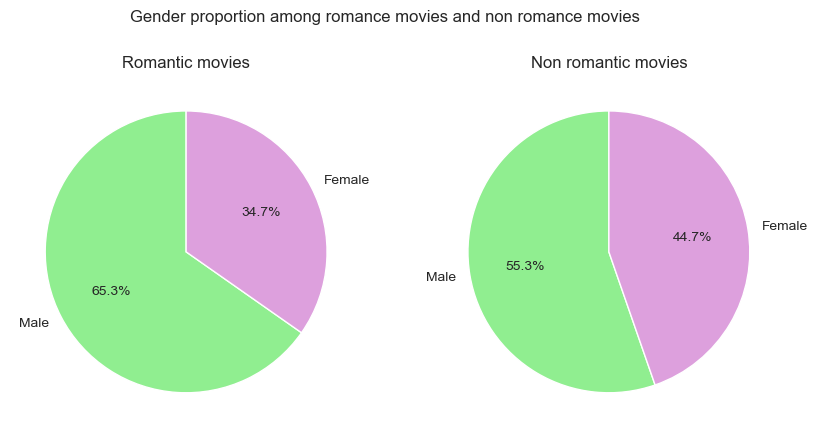

In [21]:
# Calculate percentages of gender categories in romantic and non-romantic movies
counts_romance = romance_movies_merged['Gender'].value_counts()
counts_non_romance = non_romance_movies_merged['Gender'].value_counts()
percentage_male_romance = round(counts_romance['M'] * 100/counts_romance.values.sum(), 2)
percentage_female_romance = 100 - percentage_male_romance
percentage_male_non_romance = round(counts_non_romance['M'] * 100/counts_non_romance.values.sum(), 2)
percentage_female_non_romance = 100 - percentage_male_non_romance

indices = ['Male', 'Female', 'Male', 'Female']
values = [percentage_male_non_romance, percentage_female_non_romance, percentage_male_romance, percentage_female_romance]

#Make a pie chart of the percentage of female in romance movies
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
palette_color = sns.color_palette('flare')
ax[0].pie(values[0:2], labels=indices[0:2], colors=["lightgreen", "plum"], autopct='%1.1f%%', startangle=90)
ax[1].pie(values[2:5], labels=indices[2:5], colors=[
          "lightgreen", "plum"], autopct='%1.1f%%', startangle=90)
fig.suptitle(
    'Gender proportion among romance movies and non romance movies')
ax[0].set_title('Romantic movies')
ax[1].set_title('Non romantic movies')



Next, we consider the change in the percentage of females in movies over time. The plots below show that in the first half of the 20th century, the percentage of females in movies decreased. On the other hand, the percentage of females increased in the second half of the 20th century. This effect is most visible for non-romantic movies. 

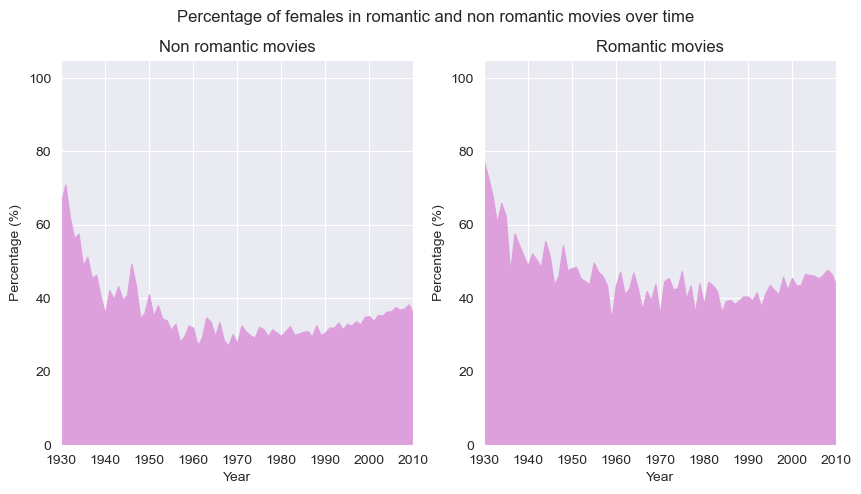

In [22]:
# Integer year of release
romance_movies_merged['Release date'] = romance_movies_merged['Release date'].astype(int)
non_romance_movies_merged['Release date'] = non_romance_movies_merged['Release date'].astype(int)

#Make binary variable for gender, where female is 1
romance_movies_merged['Binary_gender'] = romance_movies_merged['Gender'].apply(lambda x: 1 if x == 'F' else 0)
non_romance_movies_merged['Binary_gender'] = non_romance_movies_merged['Gender'].apply(lambda x: 1 if x == 'F' else 0)

# Group romance movies by year and calculate percentage of females for each year
romance_movies_merged_grouped = romance_movies_merged[['Release date', 'Binary_gender']].groupby('Release date').sum()
romance_movies_merged_grouped_count = romance_movies_merged[[
    'Release date', 'Binary_gender']].groupby('Release date').count()
percentages_romance = romance_movies_merged_grouped/romance_movies_merged_grouped_count

non_romance_movies_merged_grouped = non_romance_movies_merged[['Release date', 'Binary_gender']].groupby('Release date').sum()
non_romance_movies_merged_grouped_count = non_romance_movies_merged[[
    'Release date', 'Binary_gender']].groupby('Release date').count()
percentages_non_romance_female = (100 * non_romance_movies_merged_grouped/non_romance_movies_merged_grouped_count).astype(float)
percentages_romance_female = (100 * romance_movies_merged_grouped/romance_movies_merged_grouped_count).astype(float)
percentages_non_romance_male = 1 - percentages_non_romance_female
percentages_romance_male = 1- percentages_romance_female
x1 = percentages_non_romance_female.index.astype(float)
x2 = percentages_romance_female.index.astype(float)

#Make 2 stackplots next to eachother, of the percentage males and females in romantic and non romantic movies
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].stackplot(x1, percentages_non_romance_female['Binary_gender'].values, color = 'plum')
ax[1].stackplot(x2, percentages_romance_female['Binary_gender'].values, color = 'plum')
fig.suptitle('Percentage of females in romantic and non romantic movies over time')
ax[0].set_title('Non romantic movies')
ax[1].set_title('Romantic movies')
#Limit x-axis due to low number of movies on the tails
ax[0].set_xlim(1930, 2010)
ax[1].set_xlim(1930, 2010)
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Percentage (%)')
ax[1].set_ylabel('Percentage (%)')
ax[0].legend
ax[1].legend
plt.show()

### 3.4 Age of actor analysis <a class="anchor" id="section3-4"></a>

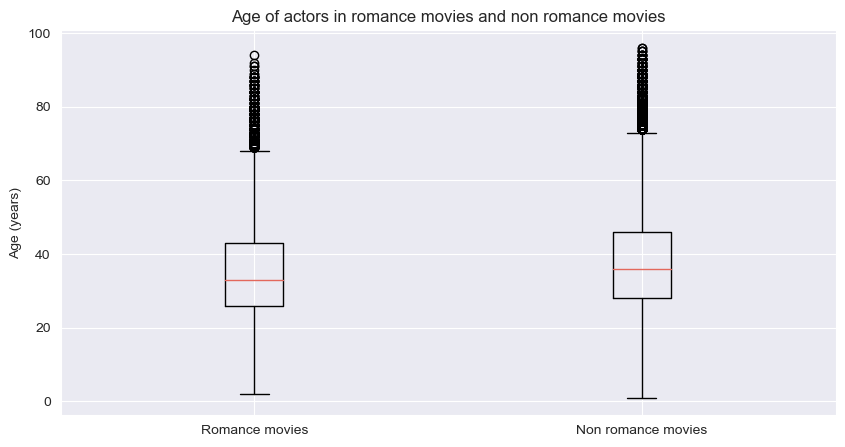

In [23]:
# Make 2 boxplots for the age of actors in romantic and non-romantic movies
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot([romance_movies_merged['Actor age at release'], non_romance_movies_merged['Actor age at release']], labels=[
              'Romance movies', 'Non romance movies'])
ax.set_title('Age of actors in romance movies and non romance movies')
ax.set_ylabel('Age (years)')
plt.show()


## 4. TV tropes <a class="anchor" id="section4"></a>
As a last part of the analysis, we evaluate the most common tv tropes clusters in romantic movies. This mostly serves as a rough indication, as only 500 movies are classified. However, this still gives an interesting image. The plot below shows that "crazy jealous guy" is the most prominent character cluster, which is not a big surprise.

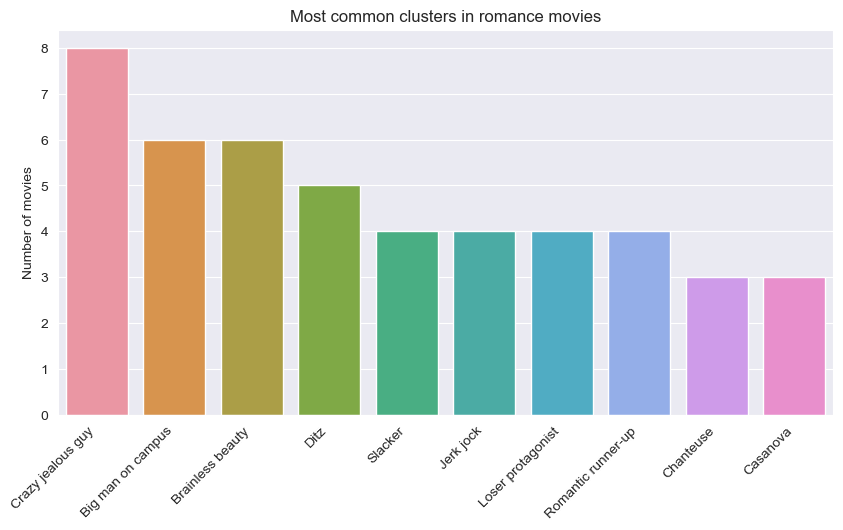

In [24]:
cluster_char = cluster_df.merge(char_df, on='Freebase character/map ID')
cluster_char_movie = cluster_char.merge(movie_df, on='Freebase ID')
romance_cluster = cluster_char_movie[cluster_char_movie['Genres'].apply(lambda x: is_romantic(slice(0, 5))(x))]

#Get most common clusters in romance movies
romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False)

#Make a seaborn plot with the 10 most common clusters in romance movies
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='Cluster', data=romance_cluster, order=romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False).head(10).index, ax=ax)
ax.set_title('Most common clusters in romance movies')
ax.set_ylabel('Number of movies')
xlabels = ['Crazy jealous guy', 'Big man on campus',
           'Brainless beauty', 'Ditz', 'Slacker', 'Jerk jock', 'Loser protagonist', 'Romantic runner-up', 'Chanteuse', 'Casanova' ]
ax.set_xticklabels(xlabels)
#Tilt x tick labels
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


In [43]:
char_relations = pd.read_csv('char_relations.csv' , sep='\t')

In [35]:
char_relations

,Wikipedia ID,Subject,Object,Romance,Subject freebase character ID,Object freebase character ID
0,12558882,Vishwam,Rukmani,False,/m/0h8n2ck,/m/0h4_vl3
1,12558882,Rukmani,Vishwam,False,/m/0h4_vl3,/m/0h8n2ck
2,2549266,Francine,Detective Terry Hoitz,False,NaN,/m/087vvp3
3,2549266,Detective Terry Hoitz,Francine,False,/m/087vvp3,NaN
4,61527,Molly,Patrick O'Leary,False,NaN,NaN
...,...,...,...,...,...,...
9911,4916040,Bruno Bonomo,Paola,True,NaN,NaN
9912,4916040,Paola,Bruno Bonomo,True,NaN,NaN
9913,893808,Wonderbot,Lydia,True,NaN,NaN
9914,301574,Prince Eric,Ursula,True,/m/0dgnkv,/m/092t__


In [32]:
cluster_char_movie

,Cluster,Character name_x,Movie,Freebase character/map ID,Actor,Wikipedia ID_x,Freebase ID,Release date_x,Character name_y,Date of birth,...,Freebase character ID,Freebase actor ID,Wikipedia ID_y,Name,Release date_y,Box office revenue,Runtime,Languages,Countries,Genres
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,1344253,/m/04vcfx,1997,Professor Philip Brainard,1951-07-21,...,/m/0cls20k,/m/0dzf_,1344253,Flubber,1997,177977226.0,93.0,[English],[United States of America],"[Science Fiction, Fantasy, Comedy, Family Film..."
1,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,5991505,/m/0fjjjh,1994,Dr. Reinhardt Lane,1939-05-25,...,/m/0gynqd6,/m/03ym1,5991505,The Shadow,1994,48063435.0,93.0,[English],[United States of America],"[Thriller, Crime Fiction, Supernatural, Superh..."
2,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,28327,/m/070g7,1994,Daniel Jackson,1960-02-07,...,/m/02qs1z,/m/043js,28327,Stargate,1994,196567262.0,121.0,"[Norwegian, English]","[United States of America, France]","[Thriller, Science Fiction, Action, Sci-Fi Adv..."
3,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,1252914,/m/04mcw4,2008,Indiana Jones,1942-07-13,...,/m/03ttl,/m/0c0k1,1252914,Indiana Jones and the Kingdom of the Crystal S...,2008,786636033.0,121.0,"[English, Russian, German]",[United States of America],"[Thriller, Adventure, Costume Adventure, Actio..."
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford,54166,/m/0f4yh,1981,Indiana Jones,1942-07-13,...,/m/03ttl,/m/0c0k1,54166,Indiana Jones and the Raiders of the Lost Ark,1981,389925971.0,115.0,"[Arabic, Nepali, Spanish, Hebrew, English, Ger...",[United States of America],"[Adventure, Costume Adventure, Action/Adventur..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,warrior_poet,T. E. Lawrence,Lawrence of Arabia,/m/0j_tdt,Peter O'Toole,43452,/m/0bx0l,1962,T. E. Lawrence,1932-08-02,...,/m/02nw8h0,/m/0h0jz,43452,Lawrence of Arabia,1962,NaN,228.0,"[Arabic, English, Turkish]","[United States of America, United Kingdom]","[LGBT, Historical fiction, Adventure, British ..."
452,warrior_poet,Horton the Elephant,Horton Hears a Who!,/m/05tgl99,Jim Carrey,6002183,/m/0fk25m,2008,Horton the Elephant,1962-01-17,...,/m/04xnbs,/m/0lx2l,6002183,Horton Hears a Who!,2008,297138014.0,88.0,[English],[United States of America],"[Computer Animation, Family Film, Animation, A..."
453,young_gun,Chico,The Magnificent Seven,/m/0k5tn5,Horst Buchholz,31556,/m/07rtf,1960,Chico,1933-12-04,...,/m/02nwpw0,/m/01b8nj,31556,The Magnificent Seven,1960,NaN,128.0,"[English, Spanish]",[United States of America],"[Action/Adventure, Western, Drama]"
454,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,81100,/m/0kyjk,1959,Colorado Ryan,1940-05-08,...,/m/0hgx0j0,/m/01wj92r,81100,Rio Bravo,1959,NaN,141.0,"[English, Spanish]",[United States of America],"[Drama, Western, Buddy film, Romance Film]"


In [50]:
# Find all characters in cluster_char_movie which are in char_relations 
char = cluster_char_movie[cluster_char_movie['Wikipedia ID_x'].isin(char_relations['Wikipedia ID'])]
# cluster_char_movie

In [59]:
char

,Cluster,Character name_x,Movie,Freebase character/map ID,Actor,Wikipedia ID_x,Freebase ID,Release date_x,Character name_y,Date of birth,...,Freebase character ID,Freebase actor ID,Wikipedia ID_y,Name,Release date_y,Box office revenue,Runtime,Languages,Countries,Genres
15,arrogant_kungfu_guy,Clubber Lang,Rocky III,/m/0k2n56,Mr. T,152328,/m/013vbq,1982,Clubber Lang,1952-05-21,...,/m/063y59,/m/04s_q,152328,Rocky III,1982,270000000.0,100.0,[English],[United States of America],"[Sports, Melodrama, Drama, Boxing]"
17,arrogant_kungfu_guy,Anakin Skywalker,Star Wars Episode III: Revenge of the Sith,/m/02sg5ry,Hayden Christensen,55447,/m/0fdv3,2005,Anakin Skywalker,1981-04-19,...,/m/0f2xj,/m/0f276,55447,Star Wars Episode III: Revenge of the Sith,2005,848754768.0,140.0,[English],[United States of America],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
18,byronic_hero,Anakin Skywalker,Star Wars Episode III: Revenge of the Sith,/m/02sg5ry,Hayden Christensen,55447,/m/0fdv3,2005,Anakin Skywalker,1981-04-19,...,/m/0f2xj,/m/0f276,55447,Star Wars Episode III: Revenge of the Sith,2005,848754768.0,140.0,[English],[United States of America],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
24,big_man_on_campus,Paul Metzler,Election,/m/02vdf9d,Chris Klein,689969,/m/032_wv,1999,Paul Metzler,1979-03-14,...,/m/0g4t99t,/m/03ptnk,689969,Election,1999,14902041.0,103.0,"[English, Spanish]",[United States of America],"[Indie, Satire, Drama, Comedy, Political cinem..."
25,brainless_beauty,Paul Metzler,Election,/m/02vdf9d,Chris Klein,689969,/m/032_wv,1999,Paul Metzler,1979-03-14,...,/m/0g4t99t,/m/03ptnk,689969,Election,1999,14902041.0,103.0,"[English, Spanish]",[United States of America],"[Indie, Satire, Drama, Comedy, Political cinem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,tranquil_fury,Max Cady,Cape Fear,/m/0jw22y,Robert De Niro,171026,/m/016y_f,1991,Max Cady,1943-08-17,...,/m/06rrdy,/m/06cgy,171026,Cape Fear,1991,182291969.0,120.0,[English],[United States of America],"[Crime Fiction, Thriller, Remake, Psychologica..."
444,trickster,Mr. Nick,The Imaginarium of Dr. Parnassus,/m/03kz4l5,Tom Waits,11312191,/m/02r79_h,2009,Mr. Nick,1949-12-07,...,/m/07ym4h3,/m/03h_fqv,11312191,The Imaginarium of Dr. Parnassus,2009,NaN,122.0,"[French, Russian, English]","[France, Canada, United Kingdom]","[Mystery, Science Fiction, Fantasy, Adventure]"
449,warrior_poet,Zohan,You Don't Mess with the Zohan,/m/03hqx35,Adam Sandler,9513043,/m/02ph9tm,2008,Zohan,1966-09-09,...,/m/0cb03np,/m/0pz91,9513043,You Don't Mess with the Zohan,2008,201802891.0,113.0,"[Hebrew, English]",[United States of America],"[Action, Drama, Comedy]"
452,warrior_poet,Horton the Elephant,Horton Hears a Who!,/m/05tgl99,Jim Carrey,6002183,/m/0fk25m,2008,Horton the Elephant,1962-01-17,...,/m/04xnbs,/m/0lx2l,6002183,Horton Hears a Who!,2008,297138014.0,88.0,[English],[United States of America],"[Computer Animation, Family Film, Animation, A..."


In [60]:
char_relations[char_relations['Wikipedia ID'] == 171026	]

,Wikipedia ID,Subject,Object,Romance,Subject freebase character ID,Object freebase character ID
17,171026,Leigh Bowden,Sam Bowden,False,/m/05lxyf2,/m/05nd8pj
18,171026,Sam Bowden,Leigh Bowden,False,/m/05nd8pj,/m/05lxyf2
19,171026,Max Cady,Leigh Bowden,False,/m/06rrdy,/m/05lxyf2


In [52]:
# Find most frequent cluster in char
char.groupby(char['Cluster']).size().sort_values(ascending=False)

Cluster
crazy_jealous_guy              10
byronic_hero                    7
tranquil_fury                   4
psycho_for_hire                 4
ophelia                         4
dumb_blonde                     3
corrupt_corporate_executive     3
arrogant_kungfu_guy             2
warrior_poet                    2
loser_protagonist               2
jerk_jock                       2
henpecked_husband               2
hardboiled_detective            2
granola_person                  2
gentleman_thief                 2
young_gun                       2
ditz                            2
dirty_cop                       2
cultured_badass                 2
chanteuse                       2
dumb_muscle                     1
casanova                        1
brainless_beauty                1
trickster                       1
bruiser_with_a_soft_center      1
the_editor                      1
stupid_crooks                   1
storyteller                     1
master_swordsman                1
prima_